In [1]:
import torch
from transformers import BertTokenizer, BertModel

In [41]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

print(model)
print(model.device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [42]:
if torch.cuda.is_available():
  model.to('cuda')

In [43]:
!pip install --upgrade datasets

In [44]:
from google.colab import drive
drive.mount('/content/drive')

# load up the dataset from the Google Drive .csv file
from datasets import load_dataset
train_dataset = load_dataset('csv', data_files='/content/drive/MyDrive/ai-laboratory/Natural Disaster Tweets/train.csv')['train']
test_dataset = load_dataset('csv', data_files='/content/drive/MyDrive/ai-laboratory/Natural Disaster Tweets/test.csv')['train']

print("Train Dataset")
print(train_dataset)
print("------------------------------------------")
print("Test Dataset")
print(test_dataset)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train Dataset
Dataset({
    features: ['id', 'keyword', 'location', 'text', 'target'],
    num_rows: 7613
})
------------------------------------------
Test Dataset
Dataset({
    features: ['id', 'keyword', 'location', 'text'],
    num_rows: 3263
})


In [45]:
# taking the tokenizer for a spin

texts = ["hello there", "goodbye friend"]
encoded_inputs = tokenizer(texts, padding=True)

print(encoded_inputs)
print(tokenizer.decode(encoded_inputs.input_ids[0]))
print(tokenizer.decode(encoded_inputs.input_ids[1]))

{'input_ids': [[101, 7592, 2045, 102], [101, 9119, 2767, 102]], 'token_type_ids': [[0, 0, 0, 0], [0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1], [1, 1, 1, 1]]}
[CLS] hello there [SEP]
[CLS] goodbye friend [SEP]


In [46]:
def custom_collate_fn(batch, split='train'):

  # get the id's
  ids = [item['id'] for item in batch]

  # get all the texts
  texts = [item['text'] for item in batch]

  # tokenize all the texts
  inputs = tokenizer(texts, padding=True, return_tensors="pt")

  input_ids = inputs.input_ids
  attention_mask = inputs.attention_mask

  labels = None # initially set labels to None
  if split == 'train':
    # create the labels tensor
    labels = torch.tensor([item['target'] for item in batch])

  outputs = {
      'ids': ids,
      'input_ids': input_ids,
      'labels': labels,
      'attention_mask': attention_mask
  }

  return outputs

In [47]:
from torch.utils.data import DataLoader
from functools import partial
batch_size = 32

# create a data loader for the training dataset
train_loader = DataLoader(train_dataset, batch_size=16, collate_fn = partial(custom_collate_fn, split='train'), shuffle=True)
for output_set in train_loader:
  print(output_set)
  break

{'ids': [6153, 4361, 3675, 6990, 875, 4281, 8069, 322, 9559, 3512, 7749, 8647, 6815, 8702, 4093, 1675], 'input_ids': tensor([[  101,  1030, 19545,  9739,  6633,  2015,  1030, 12731, 20338, 22747,
          2953,  6460,  2078,  2054,  2065,  2002,  7549,  2014,  2114,  1996,
          2813,  2005,  1996,  3308,  3114,  2021,  2059,  2002,  2234,  2041,
          1997,  7632, 17364,  5549,  1998,  2009,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  7148,  8873,  1035, 22110,  1024, 19387, 15770,  8162, 14644,
          2705,  1024,  5858,  4490,  2000,  5787,  8372,  3891,  2012,  3514,
          1998,  3806,  7051,  1064, 23348,  4183,  8299,  1024,  1013,  1013,
          1056,  1012,  2522,  1013,  1061,  6820,  2549, 16275, 14945, 12881,
          8295,  2035, 16215, 17922,  1035,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
   

In [48]:
outputs = model(torch.tensor([[101, 7592, 2045, 102]]).to('cuda'))
print(outputs.last_hidden_state.shape)
print(outputs.pooler_output.shape)

torch.Size([1, 4, 768])
torch.Size([1, 768])


In [49]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class BertClassifier(nn.Module):

  def __init__(self, base_model):
    super().__init__()
    self.base_model = base_model
    self.classification_head = nn.Linear(768, 2)


  def forward(self, input_ids, attention_mask, targets=None):
    # input_ids: (B, C), where C is context length

    last_hidden_states = self.base_model(input_ids, attention_mask=attention_mask)["last_hidden_state"] # (B, C, D)
    cls_hidden_states = last_hidden_states[:, 0, :] # (B, D)

    output_logits = self.classification_head(cls_hidden_states) # (B,D) --> (B,2)

    loss = None
    if targets is not None:
      loss = F.cross_entropy(output_logits, target=targets)

    return output_logits, loss



In [50]:
# training loop
num_epochs = 1
learning_rate = 3e-5
num_steps = 0
eval_every = 100


bert_classifier = BertClassifier(base_model = model)
bert_classifier.to('cuda')
bert_classifier.train() # put the model in training mode

optimizer = optim.Adam(bert_classifier.parameters(), lr=learning_rate)

training_loss_log = []
steps_log = []

for epoch_idx in range(num_epochs):
  for batch_data in train_loader:

    ids = batch_data['ids']
    input_ids = batch_data['input_ids'].to('cuda')
    labels = batch_data['labels'].to('cuda')
    attention_mask = batch_data['attention_mask'].to('cuda')

    output_logits, loss = bert_classifier(input_ids, attention_mask, targets=labels)


    # log the training progress here
    if num_steps % eval_every == 0:
      # calculate the number of correct samples
      _, predictions = output_logits.max(dim=1)
      num_correct = (predictions == labels).sum().item()
      total = predictions.size(0)

      print(f"Iter: {num_steps}, Loss: {loss.item()}, Accuracy: {num_correct/total}")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    training_loss_log.append(loss.item())
    steps_log.append(num_steps)


    num_steps += 1

Iter: 0, Loss: 0.7657039165496826, Accuracy: 0.375
Iter: 100, Loss: 0.3155602216720581, Accuracy: 0.875
Iter: 200, Loss: 0.4992414712905884, Accuracy: 0.6875
Iter: 300, Loss: 0.4554291069507599, Accuracy: 0.875
Iter: 400, Loss: 0.15263810753822327, Accuracy: 1.0


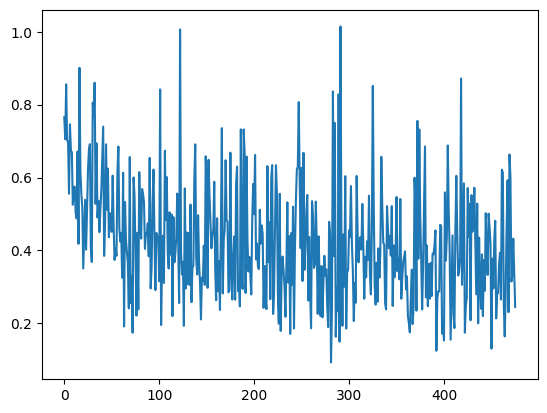

In [51]:
import matplotlib.pyplot as plt

plt.plot(steps_log, training_loss_log)

In [55]:
# evaluate on the test data
test_loader = DataLoader(test_dataset, collate_fn = partial(custom_collate_fn, split="test"), shuffle=False)
bert_classifier.eval() # put the model in eval mode

predicted_ids = []
predictions = []
num_samples = 0

for batch_data in test_loader:
    ids = batch_data['ids']
    input_ids = batch_data['input_ids'].to('cuda')
    attention_masks = batch_data['attention_mask'].to('cuda')

    output_logits, _ = bert_classifier(input_ids, attention_masks)
    _, preds = output_logits.max(dim=1)

    prediction_list = preds.tolist()

    predicted_ids.extend(ids)
    predictions.extend(prediction_list)


In [56]:
import pandas as pd


submission_data = {
    'id': predicted_ids,
    'target': predictions
}


submission_df = pd.DataFrame(submission_data)


print("Submission DataFrame head:")
print(submission_df.head())


submission_df.to_csv('submission.csv', index=False)

print("\nSuccessfully created submission.csv")

Submission DataFrame head:
   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1

Successfully created submission.csv
